In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

%matplotlib inline

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

In [3]:
#importing the datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
combined = [train,test]

In [4]:
print ('Columns: ')
print (train.columns.values)
print ('-'*20)
print ('shape: ', train.shape)

Columns: 
['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
--------------------
shape:  (891, 12)


In [5]:
print (train.info())
print ('-'*20)
print (test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-nul

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


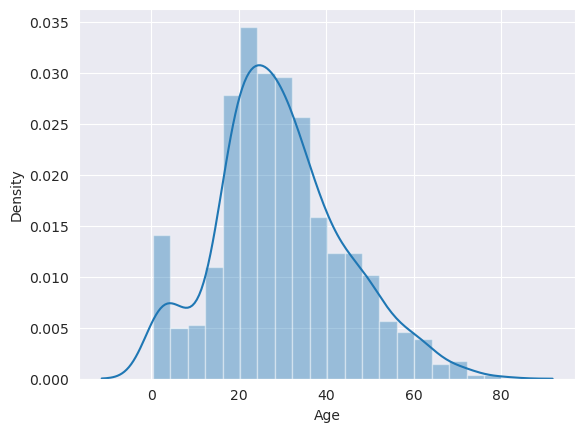

In [7]:
sns.distplot(train.Age, bins = 20)
plt.show()

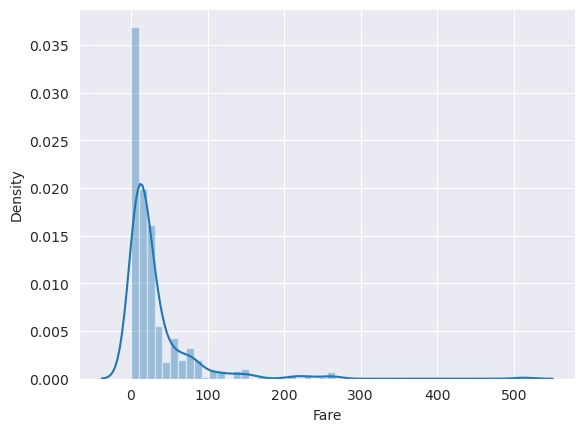

In [8]:
sns.distplot(train.Fare, bins = 50)
plt.show()

<Axes: xlabel='Sex', ylabel='count'>

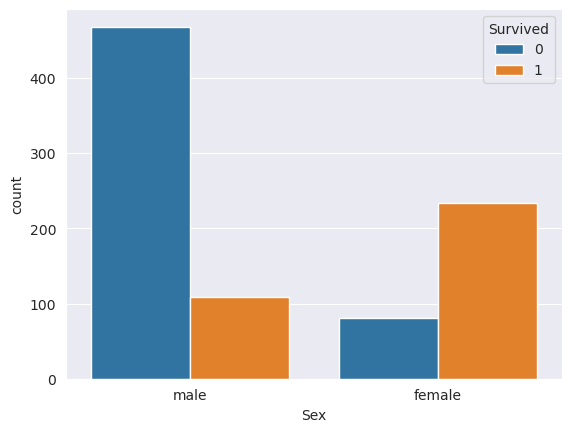

In [9]:
sns.countplot(x = train.Sex, hue = train.Survived)

In [10]:
# Calculate percentage of missing values
missing_percentage = train.isnull().sum() / len(train) * 100

# Print columns with missing values and their corresponding percentages
print(missing_percentage[missing_percentage > 0])

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64


In [11]:
for df in combined:
    df.drop(['Cabin', 'Ticket'], axis = 1, inplace = True)

In [12]:
from sklearn.impute import SimpleImputer

In [13]:
age_imputer = SimpleImputer(strategy="median")
fare_imputer = SimpleImputer(strategy="most_frequent")

for df in combined:
    df["Age"] = age_imputer.fit_transform(df[["Age"]]).ravel()
    df["Fare"] = fare_imputer.fit_transform(df[["Fare"]]).ravel()
    df["Embarked"].fillna(df['Embarked'].mode()[0], inplace = True)

In [14]:
for df in combined:
    columns_with_unique_values = []
    for column in df:
        if df[column].nunique() == len(df):
            columns_with_unique_values.append(column)
    df.drop(columns_with_unique_values, inplace = True, axis = 1)

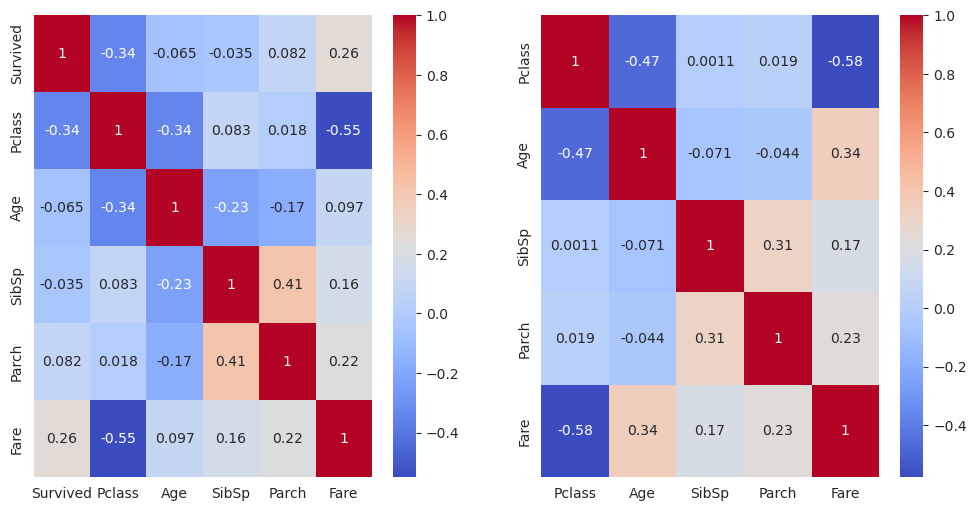

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

for i, df in enumerate(combined):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[i]) 
    
fig.show()

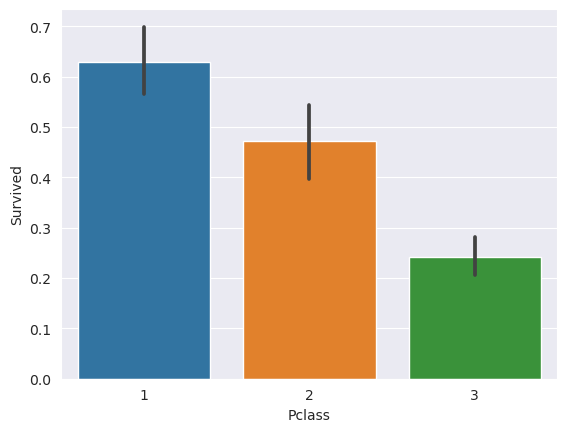

In [16]:
survival_by_Pclass = train.groupby("Pclass")["Survived"].mean()
sns.barplot(x="Pclass", y="Survived", data=train)
plt.show()

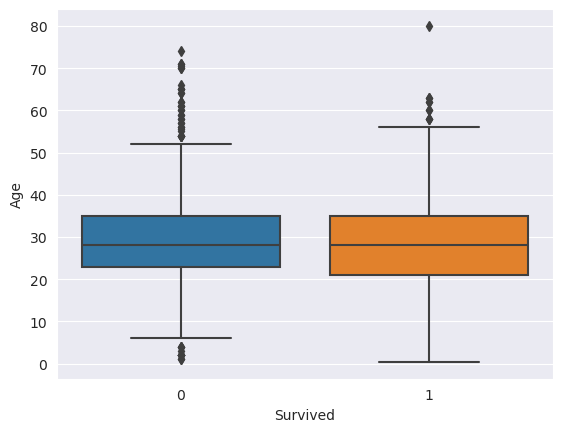

In [17]:
sns.boxplot(x="Survived", y="Age", data=train)
plt.show()

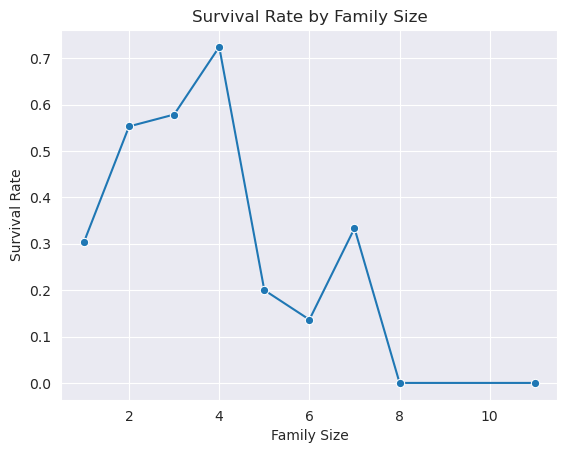

In [18]:
for df in combined:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

survival_by_family_size = train.groupby("FamilySize")["Survived"].mean()

sns.lineplot(x=survival_by_family_size.index, y=survival_by_family_size.values, marker="o")
plt.xlabel("Family Size")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Family Size")
plt.show()

In [19]:
for df in combined:
    bins = [0, 12, 18, 30, 50, 200]
    labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

    bins = [-1, 10, 30, 1000]
    labels = ['Low', 'Medium', 'High']
    df['FareGroup'] = pd.cut(df['Fare'], bins=bins, labels=labels)

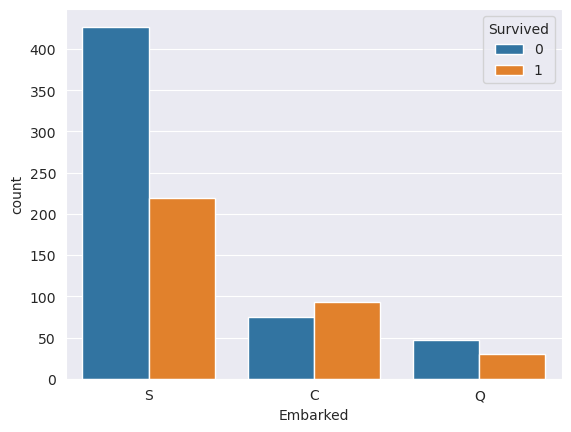

In [20]:
sns.countplot(x="Embarked", hue="Survived", data=train)
plt.show()

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

In [22]:
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']
X_test = test

In [23]:
numerical_cols = [2,5]
cat_cols = [0,1,3,4,6,7,8,9]

numerical_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop = 'first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', cat_transformer, cat_cols)
    ])

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ])

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.7877095  0.83146067 0.79213483 0.78651685 0.82022472]
Mean cross-validation score: 0.8036093151716779


In [24]:
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
svm = SVC(kernel='rbf', C=1000)
neural_network = MLPClassifier()
xgboost_model = xgb.XGBClassifier()
catboost_model = CatBoostClassifier(verbose=False)
lightgbm_model = lgb.LGBMClassifier()

In [25]:
models = [
    ('Random Forest', random_forest),
    ('Gradient Boosting', gradient_boosting),
    ('Support Vector Machines', svm),
    ('Neural Network', neural_network),
    ('XGBoost', xgboost_model),
    ('CatBoost', catboost_model),
    ('LightGBM', lightgbm_model)
]

In [26]:
model_scores = {}

numerical_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop = 'first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', cat_transformer, cat_cols)
    ])

for name, model in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    model_scores[name] = scores.mean()
    print(f"{name}:")
    print("Cross-validation scores:", scores)
    print("Mean cross-validation score:", scores.mean())
    print()

# Find the best and worst models based on cross-validation scores
best_model = max(model_scores, key=model_scores.get)
worst_model = min(model_scores, key=model_scores.get)

print("Best Model:", best_model)
print("Cross-validation score:", model_scores[best_model])
print()

print("Worst Model:", worst_model)
print("Cross-validation score:", model_scores[worst_model])
print()

Random Forest:
Cross-validation scores: [0.75977654 0.79775281 0.85955056 0.7752809  0.78651685]
Mean cross-validation score: 0.795775531981671

Gradient Boosting:
Cross-validation scores: [0.79888268 0.81460674 0.84269663 0.79775281 0.8258427 ]
Mean cross-validation score: 0.815956311593748

Support Vector Machines:
Cross-validation scores: [0.74301676 0.73595506 0.79213483 0.75842697 0.79213483]
Mean cross-validation score: 0.764333689033959

Neural Network:
Cross-validation scores: [0.7877095  0.79775281 0.83146067 0.79775281 0.83707865]
Mean cross-validation score: 0.8103508882053857

XGBoost:
Cross-validation scores: [0.78212291 0.81460674 0.85393258 0.7752809  0.83707865]
Mean cross-validation score: 0.8126043562864854

CatBoost:
Cross-validation scores: [0.81005587 0.82022472 0.84269663 0.81460674 0.83146067]
Mean cross-validation score: 0.8238089259933463

LightGBM:
Cross-validation scores: [0.79888268 0.82022472 0.84831461 0.79213483 0.84831461]
Mean cross-validation score: 0.

In [27]:
pipelines = []
for name, model in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipelines.append((name, pipeline))

# Create the VotingClassifier ensemble
ensemble = VotingClassifier(estimators=pipelines)

# Perform cross-validation on the ensemble
ensemble_scores = cross_val_score(ensemble, X_train, y_train, cv=5)

print("Ensemble of all models:")
print("Cross-validation scores:", ensemble_scores)
print("Mean cross-validation score:", ensemble_scores.mean())


Ensemble of all models:
Cross-validation scores: [0.79329609 0.83707865 0.86516854 0.79775281 0.83146067]
Mean cross-validation score: 0.8249513527085556


In [28]:
model_scores['Ensemble'] = ensemble_scores.mean()

In [29]:
model_scores

{'Random Forest': 0.795775531981671,
 'Gradient Boosting': 0.815956311593748,
 'Support Vector Machines': 0.764333689033959,
 'Neural Network': 0.8103508882053857,
 'XGBoost': 0.8126043562864854,
 'CatBoost': 0.8238089259933463,
 'LightGBM': 0.8215742891218379,
 'Ensemble': 0.8249513527085556}

In [30]:
df = pd.DataFrame.from_dict(model_scores, orient='index').rename(columns = {0:'Mean cross-validation score'})
df

,Mean cross-validation score
Random Forest,0.795776
Gradient Boosting,0.815956
Support Vector Machines,0.764334
Neural Network,0.810351
XGBoost,0.812604
CatBoost,0.823809
LightGBM,0.821574
Ensemble,0.824951


In [31]:
import datetime
print(f'Updating this notebook with new learnings (tensorflow) as of date and time {datetime.datetime.now()}.')

Updating this notebook with new learnings (tensorflow) as of date and time 2023-07-12 20:02:35.631763.


In [32]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [33]:
minmax_cols = ['Age', 'Fare']
one_hot_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'AgeGroup', 'FareGroup']

minmax = MinMaxScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)

transformer = ColumnTransformer([
    ('minmax', minmax, minmax_cols),
    ('ohe', ohe, one_hot_cols)
])

X_train_tf = transformer.fit_transform(X_train)
X_test_tf = transformer.transform(X_test)

In [34]:
X_train_tf.shape, X_test_tf.shape

((891, 33), (418, 33))

In [35]:
X_train_tf = tf.constant(X_train_tf)
X_test_tf = tf.constant(X_test_tf)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (X_train_tf.shape[1],) 

inputs = layers.Input(shape=input_shape, dtype=tf.float32)
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy',
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  
checkpoint_path = "model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              monitor='val_loss',
                              save_best_only=True,
                              verbose=1)

learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 10)

model.fit(X_train_tf,
         y_train,
         epochs = 100,
         batch_size = 32,
         validation_split = 0.2,
          verbose = 0,
         callbacks = [cp_callback, learning_rate_scheduler]
         )  


Epoch 1: val_loss improved from inf to 0.54015, saving model to model.ckpt

Epoch 2: val_loss improved from 0.54015 to 0.48909, saving model to model.ckpt

Epoch 3: val_loss improved from 0.48909 to 0.44701, saving model to model.ckpt

Epoch 4: val_loss improved from 0.44701 to 0.42240, saving model to model.ckpt

Epoch 5: val_loss improved from 0.42240 to 0.41046, saving model to model.ckpt

Epoch 6: val_loss improved from 0.41046 to 0.39815, saving model to model.ckpt

Epoch 7: val_loss improved from 0.39815 to 0.39147, saving model to model.ckpt

Epoch 8: val_loss improved from 0.39147 to 0.38351, saving model to model.ckpt

Epoch 9: val_loss did not improve from 0.38351

Epoch 10: val_loss improved from 0.38351 to 0.37702, saving model to model.ckpt

Epoch 11: val_loss improved from 0.37702 to 0.37281, saving model to model.ckpt

Epoch 12: val_loss improved from 0.37281 to 0.36868, saving model to model.ckpt

Epoch 13: val_loss improved from 0.36868 to 0.36672, saving model to mod

In [37]:
model_path = '/kaggle/working/model.ckpt'
model.load_weights(checkpoint_path)

In [38]:
from sklearn.model_selection import KFold

In [39]:
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits = 5, shuffle = True)

In [40]:
X_train_np = np.array(X_train_tf)
y_train_np = y_train.to_numpy()

num_fold = 1

for i, j in kfold.split(X_train_np, y_train_np): 

    inputs = layers.Input(shape=input_shape, dtype=tf.float32)
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(loss = 'binary_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ['accuracy'])

    print('-'*60)
    print(f'Training for fold: {num_fold}\n')

    history = model.fit(X_train_np[i],
                        y_train_np[i],
                        batch_size = 32,
                        epochs = 100,
                        verbose = 0)

    scores = model.evaluate(X_train_np[j], y_train_np[j], verbose = 0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    num_fold += 1

------------------------------------------------------------
Training for fold: 1

------------------------------------------------------------
Training for fold: 2

------------------------------------------------------------
Training for fold: 3

------------------------------------------------------------
Training for fold: 4

------------------------------------------------------------
Training for fold: 5



In [41]:
acc_per_fold, loss_per_fold

([85.47486066818237,
  78.65168452262878,
  75.84269642829895,
  82.02247023582458,
  80.89887499809265],
 [0.43943431973457336,
  0.5897753238677979,
  0.6404489874839783,
  0.5086673498153687,
  0.5652723908424377])

In [42]:
np.mean(acc_per_fold), np.mean(loss_per_fold)

(80.57811737060547, 0.5487196743488312)

Let's try TensorFlow Gradient Boosted Decision Forest.

In [43]:
minmax_cols = ['Age', 'Fare']
one_hot_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'AgeGroup', 'FareGroup']

minmax = MinMaxScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)

transformer = ColumnTransformer([
    ('minmax', minmax, minmax_cols),
    ('ohe', ohe, one_hot_cols)
])

X_train_tf = tf.constant(transformer.fit_transform(X_train))
X_test_tf = tf.constant(transformer.transform(X_test))

In [44]:
import tensorflow_decision_forests as tfdf

In [45]:
input_feats = list(X_train.columns)
input_feats

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'FamilySize',
 'AgeGroup',
 'FareGroup']

In [46]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_tf.numpy(), y_train.to_numpy()))
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [47]:
test_data = tf.data.Dataset.from_tensor_slices(X_test_tf.numpy())
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [48]:
tfdf_model = tfdf.keras.GradientBoostedTreesModel(verbose = 0)
tfdf_model.fit(train_data)
self_evaluation = tfdf_model.make_inspector().evaluation()

[WARNING 23-07-12 20:03:58.2455 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:03:58.2456 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:03:58.2456 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:06.2566 UTC kernel.cc:1242] Loading model from path /tmp/tmpp1elcfra/model/ with prefix 99c3f04b63514981
[INFO 23-07-12 20:04:06.2744 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:04:06.2744 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [49]:
self_evaluation

Evaluation(num_examples=None, accuracy=0.8767123222351074, loss=0.6601622104644775, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [50]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_15 (Dense)            (None, 128)               4352      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable

In [51]:
predictions = None
num_predictions = 0

for i in range(100):
    print(f"i:{i}")
    model = tfdf.keras.GradientBoostedTreesModel(
        verbose=0,
        random_seed=i,
        honest=True,
    )
    model.fit(train_data)
    
    sub_predictions = model.predict(test_data, verbose=0)[:,0]
    if predictions is None:
        predictions = sub_predictions
    else:
        predictions += sub_predictions
    num_predictions += 1

predictions/=num_predictions

i:0


[WARNING 23-07-12 20:04:09.0025 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:09.0025 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:09.0025 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:10.1461 UTC kernel.cc:1242] Loading model from path /tmp/tmpdu19v37v/model/ with prefix 7c667ce674724668
[INFO 23-07-12 20:04:10.1537 UTC kernel.cc:1074] Use fast generic engine


i:1


[WARNING 23-07-12 20:04:10.6163 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:10.6164 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:10.6164 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:11.9079 UTC kernel.cc:1242] Loading model from path /tmp/tmpwbt3nnil/model/ with prefix a1132384674b4426
[INFO 23-07-12 20:04:11.9170 UTC kernel.cc:1074] Use fast generic engine


i:2


[WARNING 23-07-12 20:04:12.3785 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:12.3785 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:12.3785 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:13.7459 UTC kernel.cc:1242] Loading model from path /tmp/tmprvabblx2/model/ with prefix f7778060c1164094
[INFO 23-07-12 20:04:13.7554 UTC kernel.cc:1074] Use fast generic engine


i:3


[WARNING 23-07-12 20:04:14.2033 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:14.2033 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:14.2033 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:15.3564 UTC kernel.cc:1242] Loading model from path /tmp/tmp0jv404gk/model/ with prefix 8045800447584baf
[INFO 23-07-12 20:04:15.3630 UTC kernel.cc:1074] Use fast generic engine


i:4


[WARNING 23-07-12 20:04:15.8496 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:15.8497 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:15.8497 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:16.8199 UTC kernel.cc:1242] Loading model from path /tmp/tmpbj23iqws/model/ with prefix 72571a3c21794c5b
[INFO 23-07-12 20:04:16.8239 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:04:16.8239 UTC kernel.cc:1074] Use fast generic engine


i:5


[WARNING 23-07-12 20:04:17.2923 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:17.2924 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:17.2924 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:18.2679 UTC kernel.cc:1242] Loading model from path /tmp/tmpn0tncp37/model/ with prefix 17f1960bcffc43d0
[INFO 23-07-12 20:04:18.2718 UTC kernel.cc:1074] Use fast generic engine


i:6


[WARNING 23-07-12 20:04:18.7100 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:18.7100 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:18.7101 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:19.9549 UTC kernel.cc:1242] Loading model from path /tmp/tmpdf_vzivv/model/ with prefix bf1b5510485e4f5d
[INFO 23-07-12 20:04:19.9628 UTC kernel.cc:1074] Use fast generic engine


i:7


[WARNING 23-07-12 20:04:20.4203 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:20.4203 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:20.4203 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:21.7785 UTC kernel.cc:1242] Loading model from path /tmp/tmpqoe16y0v/model/ with prefix a77db96995cc4091
[INFO 23-07-12 20:04:21.7881 UTC kernel.cc:1074] Use fast generic engine


i:8


[WARNING 23-07-12 20:04:22.2429 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:22.2429 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:22.2429 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:23.5483 UTC kernel.cc:1242] Loading model from path /tmp/tmpsigxcm32/model/ with prefix e082f4030aec4044
[INFO 23-07-12 20:04:23.5575 UTC kernel.cc:1074] Use fast generic engine


i:9


[WARNING 23-07-12 20:04:24.0328 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:24.0329 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:24.0329 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:25.2154 UTC kernel.cc:1242] Loading model from path /tmp/tmp6uw4p512/model/ with prefix 64ea363632504d3e
[INFO 23-07-12 20:04:25.2228 UTC kernel.cc:1074] Use fast generic engine


i:10


[WARNING 23-07-12 20:04:25.7523 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:25.7523 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:25.7523 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:27.1689 UTC kernel.cc:1242] Loading model from path /tmp/tmpjge9qtco/model/ with prefix 02cf3c43ff894ad4
[INFO 23-07-12 20:04:27.1795 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:04:27.1795 UTC kernel.cc:1074] Use fast generic engine


i:11


[WARNING 23-07-12 20:04:27.6217 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:27.6217 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:27.6217 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:28.8630 UTC kernel.cc:1242] Loading model from path /tmp/tmp33__pdi6/model/ with prefix 3f0cc2bbbc8249f2
[INFO 23-07-12 20:04:28.8707 UTC kernel.cc:1074] Use fast generic engine


i:12


[WARNING 23-07-12 20:04:29.3409 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:29.3410 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:29.3410 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:30.5591 UTC kernel.cc:1242] Loading model from path /tmp/tmp8ko7zamh/model/ with prefix b13d103899b14b6d
[INFO 23-07-12 20:04:30.5669 UTC kernel.cc:1074] Use fast generic engine


i:13


[WARNING 23-07-12 20:04:31.0131 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:31.0131 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:31.0131 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:32.4219 UTC kernel.cc:1242] Loading model from path /tmp/tmpay8v5otv/model/ with prefix 204d589c22084869
[INFO 23-07-12 20:04:32.4324 UTC kernel.cc:1074] Use fast generic engine


i:14


[WARNING 23-07-12 20:04:32.8821 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:32.8821 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:32.8821 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:33.9919 UTC kernel.cc:1242] Loading model from path /tmp/tmpn9699vu1/model/ with prefix 45303e77ec44410f
[INFO 23-07-12 20:04:33.9975 UTC kernel.cc:1074] Use fast generic engine


i:15


[WARNING 23-07-12 20:04:34.4261 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:34.4262 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:34.4262 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:35.4030 UTC kernel.cc:1242] Loading model from path /tmp/tmpzufulkuk/model/ with prefix 000de3e70f9d48fc
[INFO 23-07-12 20:04:35.4068 UTC kernel.cc:1074] Use fast generic engine


i:16


[WARNING 23-07-12 20:04:35.9239 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:35.9239 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:35.9240 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:37.2318 UTC kernel.cc:1242] Loading model from path /tmp/tmpik4smlzt/model/ with prefix d5e1d791b9ac45e9
[INFO 23-07-12 20:04:37.2399 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:04:37.2399 UTC kernel.cc:1074] Use fast generic engine


i:17


[WARNING 23-07-12 20:04:38.1734 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:38.1735 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:38.1735 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:39.7029 UTC kernel.cc:1242] Loading model from path /tmp/tmpeosvz5qu/model/ with prefix 9ac54bbfc1b84133
[INFO 23-07-12 20:04:39.7159 UTC kernel.cc:1074] Use fast generic engine


i:18


[WARNING 23-07-12 20:04:40.1976 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:40.1976 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:40.1976 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:41.4775 UTC kernel.cc:1242] Loading model from path /tmp/tmpb4oycz6v/model/ with prefix 0bfaf69984ab4732
[INFO 23-07-12 20:04:41.4861 UTC kernel.cc:1074] Use fast generic engine


i:19


[WARNING 23-07-12 20:04:41.9133 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:41.9136 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:41.9137 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:43.0742 UTC kernel.cc:1242] Loading model from path /tmp/tmptglp2ivq/model/ with prefix e19d127b365f4744
[INFO 23-07-12 20:04:43.0808 UTC kernel.cc:1074] Use fast generic engine


i:20


[WARNING 23-07-12 20:04:43.5282 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:43.5282 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:43.5282 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:45.1454 UTC kernel.cc:1242] Loading model from path /tmp/tmpmsakcn1d/model/ with prefix aedd2e33a68c4ed6
[INFO 23-07-12 20:04:45.1580 UTC kernel.cc:1074] Use fast generic engine


i:21


[WARNING 23-07-12 20:04:46.6501 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:46.6501 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:46.6501 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:47.6433 UTC kernel.cc:1242] Loading model from path /tmp/tmp3mo0r7op/model/ with prefix 6ae5dfed159a4de4
[INFO 23-07-12 20:04:47.6473 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:04:47.6474 UTC kernel.cc:1074] Use fast generic engine


i:22


[WARNING 23-07-12 20:04:48.0843 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:48.0843 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:48.0843 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:49.9224 UTC kernel.cc:1242] Loading model from path /tmp/tmpjgr_qbjm/model/ with prefix 81a3f02f69c348f6
[INFO 23-07-12 20:04:49.9391 UTC kernel.cc:1074] Use fast generic engine


i:23


[WARNING 23-07-12 20:04:50.4181 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:50.4182 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:50.4183 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:51.5798 UTC kernel.cc:1242] Loading model from path /tmp/tmp4dl2jdxw/model/ with prefix 6e654b614dfc4279
[INFO 23-07-12 20:04:51.5867 UTC kernel.cc:1074] Use fast generic engine


i:24


[WARNING 23-07-12 20:04:52.0254 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:52.0254 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:52.0254 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:53.4674 UTC kernel.cc:1242] Loading model from path /tmp/tmp0dz706we/model/ with prefix cffa3aedb70e4569
[INFO 23-07-12 20:04:53.4779 UTC kernel.cc:1074] Use fast generic engine


i:25


[WARNING 23-07-12 20:04:53.9502 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:53.9503 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:53.9503 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:55.3872 UTC kernel.cc:1242] Loading model from path /tmp/tmpkhpu13w0/model/ with prefix b279ccf5e47c4e6c
[INFO 23-07-12 20:04:55.3983 UTC kernel.cc:1074] Use fast generic engine


i:26


[WARNING 23-07-12 20:04:55.8915 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:55.8915 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:55.8916 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:56.9918 UTC kernel.cc:1242] Loading model from path /tmp/tmpye_vjl4n/model/ with prefix 4574d7d557c740aa
[INFO 23-07-12 20:04:56.9975 UTC kernel.cc:1074] Use fast generic engine


i:27


[WARNING 23-07-12 20:04:57.4419 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:57.4420 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:04:57.4420 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:04:59.2589 UTC kernel.cc:1242] Loading model from path /tmp/tmp_svogds7/model/ with prefix 90c894699ccc442c
[INFO 23-07-12 20:04:59.2755 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:04:59.2755 UTC kernel.cc:1074] Use fast generic engine


i:28


[WARNING 23-07-12 20:05:00.5676 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:00.5676 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:00.5676 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:01.5478 UTC kernel.cc:1242] Loading model from path /tmp/tmpnguzo8se/model/ with prefix c12bca4412204dd4
[INFO 23-07-12 20:05:01.5515 UTC kernel.cc:1074] Use fast generic engine


i:29


[WARNING 23-07-12 20:05:02.0239 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:02.0240 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:02.0240 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:03.5090 UTC kernel.cc:1242] Loading model from path /tmp/tmp7vrae8ye/model/ with prefix a4c62cea187046b1
[INFO 23-07-12 20:05:03.5197 UTC kernel.cc:1074] Use fast generic engine


i:30


[WARNING 23-07-12 20:05:03.9694 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:03.9694 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:03.9695 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:05.7858 UTC kernel.cc:1242] Loading model from path /tmp/tmpso8u70yn/model/ with prefix 7c6c66d2b89a4792
[INFO 23-07-12 20:05:05.8017 UTC kernel.cc:1074] Use fast generic engine


i:31


[WARNING 23-07-12 20:05:06.2566 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:06.2566 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:06.2567 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:07.6062 UTC kernel.cc:1242] Loading model from path /tmp/tmpess3j_fo/model/ with prefix 9377c35dda30462c
[INFO 23-07-12 20:05:07.6162 UTC kernel.cc:1074] Use fast generic engine


i:32


[WARNING 23-07-12 20:05:08.0610 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:08.0610 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:08.0610 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:09.2445 UTC kernel.cc:1242] Loading model from path /tmp/tmpqsrddicd/model/ with prefix e475fb2eade049c7
[INFO 23-07-12 20:05:09.2511 UTC kernel.cc:1074] Use fast generic engine


i:33


[WARNING 23-07-12 20:05:09.6944 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:09.6944 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:09.6944 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:10.9184 UTC kernel.cc:1242] Loading model from path /tmp/tmp2zwckwi4/model/ with prefix d29f7ca57f414d23
[INFO 23-07-12 20:05:10.9265 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:05:10.9265 UTC kernel.cc:1074] Use fast generic engine


i:34


[WARNING 23-07-12 20:05:11.3667 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:11.3668 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:11.3668 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:12.4199 UTC kernel.cc:1242] Loading model from path /tmp/tmp1yrmhv8g/model/ with prefix b1454722b56a43a2
[INFO 23-07-12 20:05:12.4256 UTC kernel.cc:1074] Use fast generic engine


i:35


[WARNING 23-07-12 20:05:12.8725 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:12.8725 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:12.8725 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:13.9079 UTC kernel.cc:1242] Loading model from path /tmp/tmp1290swzw/model/ with prefix a9e3c9623d7a43c3
[INFO 23-07-12 20:05:13.9127 UTC kernel.cc:1074] Use fast generic engine


i:36


[WARNING 23-07-12 20:05:14.3860 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:14.3860 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:14.3860 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:15.8966 UTC kernel.cc:1242] Loading model from path /tmp/tmpdwijo7zw/model/ with prefix 27d3e42c253f464c
[INFO 23-07-12 20:05:15.9081 UTC kernel.cc:1074] Use fast generic engine


i:37


[WARNING 23-07-12 20:05:16.3818 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:16.3818 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:16.3818 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:17.4237 UTC kernel.cc:1242] Loading model from path /tmp/tmp8rxa47zp/model/ with prefix c12c8072aac94185
[INFO 23-07-12 20:05:17.4287 UTC kernel.cc:1074] Use fast generic engine


i:38


[WARNING 23-07-12 20:05:17.9060 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:17.9061 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:17.9061 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:19.4349 UTC kernel.cc:1242] Loading model from path /tmp/tmpi05ydbrn/model/ with prefix 810f0b4e8a1c44bb
[INFO 23-07-12 20:05:19.4469 UTC kernel.cc:1074] Use fast generic engine


i:39


[WARNING 23-07-12 20:05:19.9156 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:19.9157 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:19.9157 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:22.0676 UTC kernel.cc:1242] Loading model from path /tmp/tmp4txbvb3y/model/ with prefix 1c4b977ab141436b
[INFO 23-07-12 20:05:22.0885 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:05:22.0886 UTC kernel.cc:1074] Use fast generic engine


i:40


[WARNING 23-07-12 20:05:22.5537 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:22.5537 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:22.5537 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:23.7873 UTC kernel.cc:1242] Loading model from path /tmp/tmpfve33s1t/model/ with prefix 2d870ba43bcf4bb2
[INFO 23-07-12 20:05:23.7951 UTC kernel.cc:1074] Use fast generic engine


i:41


[WARNING 23-07-12 20:05:24.2436 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:24.2436 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:24.2436 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:25.5026 UTC kernel.cc:1242] Loading model from path /tmp/tmp33pvb4yt/model/ with prefix 4f4c0aa9e75944a8
[INFO 23-07-12 20:05:25.5104 UTC kernel.cc:1074] Use fast generic engine


i:42


[WARNING 23-07-12 20:05:26.0021 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:26.0021 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:26.0021 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:27.3364 UTC kernel.cc:1242] Loading model from path /tmp/tmpii9tzclr/model/ with prefix 386f3fd31c9a40ce
[INFO 23-07-12 20:05:27.3460 UTC kernel.cc:1074] Use fast generic engine


i:43


[WARNING 23-07-12 20:05:27.8125 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:27.8126 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:27.8126 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:29.8040 UTC kernel.cc:1242] Loading model from path /tmp/tmpvpklg0qw/model/ with prefix 160a616b5ca44dff
[INFO 23-07-12 20:05:29.8158 UTC kernel.cc:1074] Use fast generic engine


i:44


[WARNING 23-07-12 20:05:30.2707 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:30.2708 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:30.2708 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:31.2593 UTC kernel.cc:1242] Loading model from path /tmp/tmp6599kaqx/model/ with prefix d19b8d3a2dfb40f9
[INFO 23-07-12 20:05:31.2633 UTC kernel.cc:1074] Use fast generic engine


i:45


[WARNING 23-07-12 20:05:31.6966 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:31.6966 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:31.6966 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:32.7340 UTC kernel.cc:1242] Loading model from path /tmp/tmp11pptbry/model/ with prefix 132a7e0ba8864254
[INFO 23-07-12 20:05:32.7396 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:05:32.7396 UTC kernel.cc:1074] Use fast generic engine


i:46


[WARNING 23-07-12 20:05:33.1720 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:33.1721 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:33.1721 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:35.1417 UTC kernel.cc:1242] Loading model from path /tmp/tmp9jmr1qa6/model/ with prefix 84be8319ba7a4f13
[INFO 23-07-12 20:05:35.1606 UTC kernel.cc:1074] Use fast generic engine


i:47


[WARNING 23-07-12 20:05:35.7187 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:35.7187 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:35.7187 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:36.9483 UTC kernel.cc:1242] Loading model from path /tmp/tmpq6cc_6dv/model/ with prefix 70e603d9e7e64348
[INFO 23-07-12 20:05:36.9577 UTC kernel.cc:1074] Use fast generic engine


i:48


[WARNING 23-07-12 20:05:37.4491 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:37.4491 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:37.4492 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:38.5419 UTC kernel.cc:1242] Loading model from path /tmp/tmp5eud_ifm/model/ with prefix ec931abeb50a463f
[INFO 23-07-12 20:05:38.5478 UTC kernel.cc:1074] Use fast generic engine


i:49


[WARNING 23-07-12 20:05:39.0196 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:39.0196 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:39.0196 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:40.0733 UTC kernel.cc:1242] Loading model from path /tmp/tmpgd1xvuug/model/ with prefix 4799c4ee83c54dd1
[INFO 23-07-12 20:05:40.0790 UTC kernel.cc:1074] Use fast generic engine


i:50


[WARNING 23-07-12 20:05:40.5236 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:40.5236 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:40.5236 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:41.8997 UTC kernel.cc:1242] Loading model from path /tmp/tmp9h77hz84/model/ with prefix 1b88dceed53f4851
[INFO 23-07-12 20:05:41.9099 UTC kernel.cc:1074] Use fast generic engine


i:51


[WARNING 23-07-12 20:05:42.3776 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:42.3776 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:42.3776 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:43.8464 UTC kernel.cc:1242] Loading model from path /tmp/tmp6t__nelp/model/ with prefix 15ffc0f35b3944a0
[INFO 23-07-12 20:05:43.8580 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:05:43.8580 UTC kernel.cc:1074] Use fast generic engine


i:52


[WARNING 23-07-12 20:05:44.2828 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:44.2829 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:44.2829 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:45.4739 UTC kernel.cc:1242] Loading model from path /tmp/tmpivli37n0/model/ with prefix f9d3787562914df3
[INFO 23-07-12 20:05:45.4810 UTC kernel.cc:1074] Use fast generic engine


i:53


[WARNING 23-07-12 20:05:45.9694 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:45.9694 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:45.9694 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:47.3378 UTC kernel.cc:1242] Loading model from path /tmp/tmp059pf8n1/model/ with prefix 68d21e7742224182
[INFO 23-07-12 20:05:47.3484 UTC kernel.cc:1074] Use fast generic engine


i:54


[WARNING 23-07-12 20:05:47.7987 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:47.7987 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:47.7987 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:48.8919 UTC kernel.cc:1242] Loading model from path /tmp/tmpo12y3fw0/model/ with prefix d98e0d3cb7844b2c
[INFO 23-07-12 20:05:48.8976 UTC kernel.cc:1074] Use fast generic engine


i:55


[WARNING 23-07-12 20:05:49.3391 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:49.3392 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:49.3392 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:51.4223 UTC kernel.cc:1242] Loading model from path /tmp/tmp9y87s9km/model/ with prefix 1530730803584e52
[INFO 23-07-12 20:05:51.4438 UTC kernel.cc:1074] Use fast generic engine


i:56


[WARNING 23-07-12 20:05:51.9315 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:51.9315 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:51.9315 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:53.1041 UTC kernel.cc:1242] Loading model from path /tmp/tmpac3km13r/model/ with prefix 01df2e0324b14317
[INFO 23-07-12 20:05:53.1112 UTC kernel.cc:1074] Use fast generic engine


i:57


[WARNING 23-07-12 20:05:53.5569 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:53.5569 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:53.5570 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:54.5416 UTC kernel.cc:1242] Loading model from path /tmp/tmptfmbaim5/model/ with prefix db919c67ac514522
[INFO 23-07-12 20:05:54.5455 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:05:54.5455 UTC kernel.cc:1074] Use fast generic engine


i:58


[WARNING 23-07-12 20:05:54.9981 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:54.9981 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:54.9982 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:56.1335 UTC kernel.cc:1242] Loading model from path /tmp/tmpylz9rq0z/model/ with prefix 4e255eb0199a4465
[INFO 23-07-12 20:05:56.1397 UTC kernel.cc:1074] Use fast generic engine


i:59


[WARNING 23-07-12 20:05:56.5966 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:56.5967 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:56.5967 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:58.0780 UTC kernel.cc:1242] Loading model from path /tmp/tmpsaqjjnqy/model/ with prefix e396f9acf720465e
[INFO 23-07-12 20:05:58.0896 UTC kernel.cc:1074] Use fast generic engine


i:60


[WARNING 23-07-12 20:05:58.5354 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:58.5355 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:05:58.5355 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:05:59.5564 UTC kernel.cc:1242] Loading model from path /tmp/tmphrawj_le/model/ with prefix 9c80c29601dd4149
[INFO 23-07-12 20:05:59.5609 UTC kernel.cc:1074] Use fast generic engine


i:61


[WARNING 23-07-12 20:06:00.0046 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:00.0046 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:00.0046 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:01.2527 UTC kernel.cc:1242] Loading model from path /tmp/tmp706_58vw/model/ with prefix 2090cab54421428e
[INFO 23-07-12 20:06:01.2606 UTC kernel.cc:1074] Use fast generic engine


i:62


[WARNING 23-07-12 20:06:01.7047 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:01.7047 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:01.7048 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:03.4553 UTC kernel.cc:1242] Loading model from path /tmp/tmp2t7j08lq/model/ with prefix 486f068b4a7f4179
[INFO 23-07-12 20:06:03.4703 UTC kernel.cc:1074] Use fast generic engine


i:63


[WARNING 23-07-12 20:06:04.8657 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:04.8657 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:04.8657 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:06.3087 UTC kernel.cc:1242] Loading model from path /tmp/tmpl37n5oej/model/ with prefix ffd6f48e389647c1
[INFO 23-07-12 20:06:06.3187 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:06:06.3187 UTC kernel.cc:1074] Use fast generic engine


i:64


[WARNING 23-07-12 20:06:06.7899 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:06.7899 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:06.7899 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:07.7838 UTC kernel.cc:1242] Loading model from path /tmp/tmpxodtcdfo/model/ with prefix dfd35f3f050648b2
[INFO 23-07-12 20:06:07.7881 UTC kernel.cc:1074] Use fast generic engine


i:65


[WARNING 23-07-12 20:06:08.2530 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:08.2531 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:08.2531 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:09.2866 UTC kernel.cc:1242] Loading model from path /tmp/tmp7bl4xpx0/model/ with prefix 2422f86dc811461f
[INFO 23-07-12 20:06:09.2915 UTC kernel.cc:1074] Use fast generic engine


i:66


[WARNING 23-07-12 20:06:09.7416 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:09.7416 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:09.7417 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:11.3428 UTC kernel.cc:1242] Loading model from path /tmp/tmp5a75brvh/model/ with prefix 7f8b0a02eb5b4041
[INFO 23-07-12 20:06:11.3565 UTC kernel.cc:1074] Use fast generic engine


i:67


[WARNING 23-07-12 20:06:11.8194 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:11.8194 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:11.8195 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:13.0651 UTC kernel.cc:1242] Loading model from path /tmp/tmpvj722n5z/model/ with prefix 765578fd82824960
[INFO 23-07-12 20:06:13.0738 UTC kernel.cc:1074] Use fast generic engine


i:68


[WARNING 23-07-12 20:06:13.5594 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:13.5595 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:13.5595 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:14.9530 UTC kernel.cc:1242] Loading model from path /tmp/tmpxnsikryr/model/ with prefix 56cff1cb072e4f60
[INFO 23-07-12 20:06:14.9630 UTC kernel.cc:1074] Use fast generic engine


i:69


[WARNING 23-07-12 20:06:15.4141 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:15.4142 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:15.4142 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:16.5354 UTC kernel.cc:1242] Loading model from path /tmp/tmpii6pno36/model/ with prefix cbf400629bcc48c6
[INFO 23-07-12 20:06:16.5409 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:06:16.5410 UTC kernel.cc:1074] Use fast generic engine


i:70


[WARNING 23-07-12 20:06:16.9855 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:16.9855 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:16.9855 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:18.1955 UTC kernel.cc:1242] Loading model from path /tmp/tmp2ol2pg38/model/ with prefix d320810f608e4e45
[INFO 23-07-12 20:06:18.2028 UTC kernel.cc:1074] Use fast generic engine


i:71


[WARNING 23-07-12 20:06:18.6654 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:18.6654 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:18.6654 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:19.8904 UTC kernel.cc:1242] Loading model from path /tmp/tmpm4gft_41/model/ with prefix 254bbcf5dd6b44c4
[INFO 23-07-12 20:06:19.8978 UTC kernel.cc:1074] Use fast generic engine


i:72


[WARNING 23-07-12 20:06:20.3657 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:20.3657 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:20.3657 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:21.8315 UTC kernel.cc:1242] Loading model from path /tmp/tmpepwenh3o/model/ with prefix 79a92ca4e8374781
[INFO 23-07-12 20:06:21.8429 UTC kernel.cc:1074] Use fast generic engine


i:73


[WARNING 23-07-12 20:06:22.3299 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:22.3299 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:22.3300 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:23.4161 UTC kernel.cc:1242] Loading model from path /tmp/tmphkua54c8/model/ with prefix 664fe4f2bf2b4189
[INFO 23-07-12 20:06:23.4219 UTC kernel.cc:1074] Use fast generic engine


i:74


[WARNING 23-07-12 20:06:23.8493 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:23.8494 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:23.8494 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:25.9931 UTC kernel.cc:1242] Loading model from path /tmp/tmp3pjjzr1e/model/ with prefix df773204a02444c4
[INFO 23-07-12 20:06:26.0027 UTC kernel.cc:1074] Use fast generic engine


i:75


[WARNING 23-07-12 20:06:26.4754 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:26.4755 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:26.4755 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:27.6826 UTC kernel.cc:1242] Loading model from path /tmp/tmp3cnywjr0/model/ with prefix 0095a1356f414af5
[INFO 23-07-12 20:06:27.6907 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:06:27.6908 UTC kernel.cc:1074] Use fast generic engine


i:76


[WARNING 23-07-12 20:06:28.1505 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:28.1505 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:28.1506 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:29.1122 UTC kernel.cc:1242] Loading model from path /tmp/tmp8e52v2jm/model/ with prefix 3f5e54c079344860
[INFO 23-07-12 20:06:29.1159 UTC kernel.cc:1074] Use fast generic engine


i:77


[WARNING 23-07-12 20:06:29.5674 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:29.5674 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:29.5674 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:30.7850 UTC kernel.cc:1242] Loading model from path /tmp/tmp8niqsd5s/model/ with prefix 4549d8980a7f4535
[INFO 23-07-12 20:06:30.7926 UTC kernel.cc:1074] Use fast generic engine


i:78


[WARNING 23-07-12 20:06:31.2288 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:31.2288 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:31.2288 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:32.6907 UTC kernel.cc:1242] Loading model from path /tmp/tmpwvvxnruv/model/ with prefix 343410ac3723406e
[INFO 23-07-12 20:06:32.7023 UTC kernel.cc:1074] Use fast generic engine


i:79


[WARNING 23-07-12 20:06:33.1557 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:33.1557 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:33.1558 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:34.2163 UTC kernel.cc:1242] Loading model from path /tmp/tmpharf_md_/model/ with prefix b685d50ea5044518
[INFO 23-07-12 20:06:34.2220 UTC kernel.cc:1074] Use fast generic engine


i:80


[WARNING 23-07-12 20:06:34.6814 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:34.6814 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:34.6815 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:36.1443 UTC kernel.cc:1242] Loading model from path /tmp/tmpdlm8lhz0/model/ with prefix d622917e88cb4d09
[INFO 23-07-12 20:06:36.1547 UTC kernel.cc:1074] Use fast generic engine


i:81


[WARNING 23-07-12 20:06:36.6004 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:36.6005 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:36.6005 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:37.7936 UTC kernel.cc:1242] Loading model from path /tmp/tmpmpcfkbh5/model/ with prefix 8045a99b9d0c41e8
[INFO 23-07-12 20:06:37.8010 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:06:37.8011 UTC kernel.cc:1074] Use fast generic engine


i:82


[WARNING 23-07-12 20:06:38.2442 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:38.2442 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:38.2442 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:39.2825 UTC kernel.cc:1242] Loading model from path /tmp/tmpybdn4btb/model/ with prefix 4eab70fcf3fd4a0d
[INFO 23-07-12 20:06:39.2876 UTC kernel.cc:1074] Use fast generic engine


i:83


[WARNING 23-07-12 20:06:39.7486 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:39.7486 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:39.7486 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:40.8416 UTC kernel.cc:1242] Loading model from path /tmp/tmphypi2xe6/model/ with prefix 990cee95da19402d
[INFO 23-07-12 20:06:40.8476 UTC kernel.cc:1074] Use fast generic engine


i:84


[WARNING 23-07-12 20:06:41.3625 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:41.3634 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:41.3640 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:43.3771 UTC kernel.cc:1242] Loading model from path /tmp/tmpmkysgbvs/model/ with prefix 3eba49189c4b47c9
[INFO 23-07-12 20:06:43.3912 UTC kernel.cc:1074] Use fast generic engine


i:85


[WARNING 23-07-12 20:06:43.8606 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:43.8607 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:43.8607 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:44.7657 UTC kernel.cc:1242] Loading model from path /tmp/tmpurpcmxoe/model/ with prefix a7738081c9664459
[INFO 23-07-12 20:06:44.7685 UTC kernel.cc:1074] Use fast generic engine


i:86


[WARNING 23-07-12 20:06:45.2122 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:45.2122 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:45.2122 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:46.4818 UTC kernel.cc:1242] Loading model from path /tmp/tmp_j94z0wj/model/ with prefix 32674c6689164823
[INFO 23-07-12 20:06:46.4894 UTC kernel.cc:1074] Use fast generic engine


i:87


[WARNING 23-07-12 20:06:47.1165 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:47.1165 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:47.1166 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:48.2801 UTC kernel.cc:1242] Loading model from path /tmp/tmp84yiye8q/model/ with prefix b5947cf3fbfb4e92
[INFO 23-07-12 20:06:48.2873 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:06:48.2873 UTC kernel.cc:1074] Use fast generic engine


i:88


[WARNING 23-07-12 20:06:48.7283 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:48.7283 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:48.7284 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:50.1558 UTC kernel.cc:1242] Loading model from path /tmp/tmp2ghgvkis/model/ with prefix e1fa6a9338514fd1
[INFO 23-07-12 20:06:50.1666 UTC kernel.cc:1074] Use fast generic engine


i:89


[WARNING 23-07-12 20:06:50.6413 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:50.6413 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:50.6413 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:52.0346 UTC kernel.cc:1242] Loading model from path /tmp/tmpht1csznb/model/ with prefix f8ceb10a469145b6
[INFO 23-07-12 20:06:52.0446 UTC kernel.cc:1074] Use fast generic engine


i:90


[WARNING 23-07-12 20:06:52.5043 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:52.5043 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:52.5044 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:54.9198 UTC kernel.cc:1242] Loading model from path /tmp/tmppxsnpd2m/model/ with prefix db7b8e7ba0d84097
[INFO 23-07-12 20:06:54.9456 UTC kernel.cc:1074] Use fast generic engine


i:91


[WARNING 23-07-12 20:06:55.4203 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:55.4204 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:55.4204 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:56.9293 UTC kernel.cc:1242] Loading model from path /tmp/tmpcmtmvtdg/model/ with prefix b69a63e51f9f4fed
[INFO 23-07-12 20:06:56.9408 UTC kernel.cc:1074] Use fast generic engine


i:92


[WARNING 23-07-12 20:06:57.4090 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:57.4090 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:57.4090 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:06:59.2561 UTC kernel.cc:1242] Loading model from path /tmp/tmp7vv7n11l/model/ with prefix e2c669c9d70d48ef
[INFO 23-07-12 20:06:59.2719 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:06:59.2720 UTC kernel.cc:1074] Use fast generic engine


i:93


[WARNING 23-07-12 20:06:59.7142 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:59.7142 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:06:59.7142 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:07:01.2100 UTC kernel.cc:1242] Loading model from path /tmp/tmpaguwyd57/model/ with prefix df19db47bca14c0c
[INFO 23-07-12 20:07:01.2234 UTC kernel.cc:1074] Use fast generic engine


i:94


[WARNING 23-07-12 20:07:01.7062 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:01.7062 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:01.7062 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:07:02.7191 UTC kernel.cc:1242] Loading model from path /tmp/tmpsygax1go/model/ with prefix b12ba4747aa4449d
[INFO 23-07-12 20:07:02.7234 UTC kernel.cc:1074] Use fast generic engine


i:95


[WARNING 23-07-12 20:07:03.1978 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:03.1978 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:03.1979 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:07:04.1739 UTC kernel.cc:1242] Loading model from path /tmp/tmpbo6ja768/model/ with prefix 9e2bc5d841ba480d
[INFO 23-07-12 20:07:04.1776 UTC kernel.cc:1074] Use fast generic engine


i:96


[WARNING 23-07-12 20:07:04.6458 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:04.6459 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:04.6459 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:07:06.2962 UTC kernel.cc:1242] Loading model from path /tmp/tmplt3hnas7/model/ with prefix 18651f4dc96f4004
[INFO 23-07-12 20:07:06.3091 UTC kernel.cc:1074] Use fast generic engine


i:97


[WARNING 23-07-12 20:07:06.7622 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:06.7624 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:06.7626 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:07:07.8929 UTC kernel.cc:1242] Loading model from path /tmp/tmpn9o04pox/model/ with prefix 33f7936074674703
[INFO 23-07-12 20:07:07.8989 UTC kernel.cc:1074] Use fast generic engine


i:98


[WARNING 23-07-12 20:07:08.3330 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:08.3331 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:08.3331 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:07:10.5780 UTC kernel.cc:1242] Loading model from path /tmp/tmps4zkzae1/model/ with prefix 14bd80cad7764618
[INFO 23-07-12 20:07:10.6007 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-12 20:07:10.6007 UTC kernel.cc:1074] Use fast generic engine


i:99


[WARNING 23-07-12 20:07:11.0607 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:11.0607 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-12 20:07:11.0608 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-12 20:07:12.7970 UTC kernel.cc:1242] Loading model from path /tmp/tmpjir4yb91/model/ with prefix a394ac8e39fd4cee
[INFO 23-07-12 20:07:12.8118 UTC kernel.cc:1074] Use fast generic engine


In [52]:
predictions_t = np.where(predictions >= 0.5, 1, 0)

In [53]:
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
submission['Survived'] = predictions_t
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [54]:
submission.to_csv('submission.csv', index = False)